In [2]:
import sys
sys.path.insert(1,'..')
import learnHeat as lh
from importlib import reload
lh = reload(lh)
import pygsp as pg
import numpy as np

In [37]:
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)
L = np.zeros((6,6))
L[0,1] = 0.0000001
L[0,2] = 0.402
L[0,3] = 0.407
L[1,3] = 0.409
L[3,5] = 0.013
L[4,5] = 0.012
L[3,4] = 0.012
L[0,1] = 0.8
L[4,4] = 0.3
L = -(L+L.T)
np.fill_diagonal(L,-np.sum(L,axis=1))
L = L/np.trace(L)*6
L

array([[ 2.04968, -1.01911, -0.5121 , -0.51847, -0.     , -0.     ],
       [-1.01911,  1.54013, -0.     , -0.52102, -0.     , -0.     ],
       [-0.5121 , -0.     ,  0.5121 , -0.     , -0.     , -0.     ],
       [-0.51847, -0.52102, -0.     ,  1.07134, -0.01529, -0.01656],
       [-0.     , -0.     , -0.     , -0.01529,  0.7949 , -0.01529],
       [-0.     , -0.     , -0.     , -0.01656, -0.01529,  0.03185]])

array([[-0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0.],
       [-0., -0.,  0., -0., -0.,  0.],
       [-0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0.,  0.,  0.],
       [-0., -0.,  0., -0.,  0.,  0.]])

We need a function that takes the Laplacian and spits the most persistent Laplacian and do scores with that
(F-measure, precision, recall, NMI), so we should do it with different kinds of graphs, so
with threshold at 0.01 and with threshold at random

In [35]:
import random
import scores_table as scort

trial = np.load('trials2.npy')
trial += 1
experiments = 100
N = 20
tau0 = [1,2.5,4]
regularizers = np.array([0.25,0.5,1,2,4,8,16])
array = np.zeros([experiments,4,len(regularizers)+1])
max_iter = 50
for i in range(experiments):
    print(i)
    L1 = lh.heat_graph_RBF(N,kappa=0.75,sigma=0.5)
    L2 = lh.heat_graph_RBF(N,kappa=0.3,sigma=0.5)
    L3 = lh.heat_graph_ER(N)
    L4 = lh.heat_graph_BA(N)
    length = random.randint(1,3)
    taus = []
    for _ in range(length):
        taus.append(random.random()*4)
    X1 = lh.create_deltas(L1,taus)
    X2 = lh.create_deltas(L1,taus)
    X3 = lh.create_deltas(L1,taus)
    X4 = lh.create_deltas(L1,taus)
    res1 = lh.learn_heat(X1,tau0=tau0[:length],alpha=0.01,beta=0.1,max_iter=max_iter)
    res2 = lh.learn_heat(X2,tau0=tau0[:length],alpha=0.01,beta=0.1,max_iter=max_iter)
    res3 = lh.learn_heat(X3,tau0=tau0[:length],alpha=0.01,beta=0.1,max_iter=max_iter)
    res4 = lh.learn_heat(X4,tau0=tau0[:length],alpha=0.01,beta=0.1,max_iter=max_iter)
    LL1 = res1["L"]
    LL2 = res2["L"]
    LL3 = res3["L"]
    LL4 = res4["L"]

    for r in range(len(regularizers)):
        _, a, _ = lh.filter_least_persistent(LL1,softness=N,reg=regularizers[r])
        array[i,0,r] = scort.scores(a,L1)
        array[i,0,-1] = scort.scores(lh.filter_mean(LL1),L1)
        _, b, _ = lh.filter_least_persistent(LL2,softness=N,reg=regularizers[r])
        array[i,1,r] = scort.scores(b,L2)
        array[i,1,-1] = scort.scores(lh.filter_mean(LL2),L2)
        _, c, _ = lh.filter_least_persistent(LL3,softness=N,reg=regularizers[r])
        array[i,2,r] = scort.scores(c,L3)
        array[i,2,-1] = scort.scores(lh.filter_mean(LL3),L3)
        _, d, _ = lh.filter_least_persistent(LL4,softness=N,reg=regularizers[r])
        array[i,3,r] = scort.scores(d,L4)
        array[i,3,-1] = scort.scores(lh.filter_mean(LL4),L4)
        ## do it also with the mean?

np.save(f"reg{trial}_experiments{experiments}_N{N}_iter{max_iter}.npy",array)
np.save("trials2.npy",trial)

0


/home/aner/Documents/math/learning_graphs/persistence/../learnHeat.py:545: RuntimeWarning: overflow encountered in scalar multiply
  max_elem = np.max(jumps)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [39]:
np.mean(array,axis=0)

array([[0.40420445, 0.41269429, 0.41589555, 0.41433974, 0.39476961,
        0.3876915 , 0.38683407, 0.33449022],
       [0.72552753, 0.69415665, 0.64653077, 0.58727352, 0.53319804,
        0.5407885 , 0.50960756, 0.88207599],
       [0.4065689 , 0.38378302, 0.36732658, 0.33663379, 0.31102582,
        0.32396541, 0.29378596, 0.47022086],
       [0.22960843, 0.23274552, 0.2108639 , 0.19524233, 0.18549544,
        0.18649836, 0.18731258, 0.27537067]])

In [14]:
L1.shape[1]

20

### Erdös-Rényi

In [3]:
### 100 experiments, 100 random graphs, 3 lists
import random
import scores_table as scort

trial = np.load('trials.npy')
trial += 1
experiments = 100
N = 20
type = 'RBF'
tau0 = [1,2.5,4]
thresh = 1/N-1
reverse=True
array = np.zeros([experiments,4])
max_iter = 50
for i in range(experiments):
    print(i,flush=True)
    L_ground = lh.heat_graph_RBF(N,kappa=0.3,sigma=0.5)
    length = random.randint(1,3)
    taus = []
    for _ in range(length):
        taus.append(random.random()*4)
    X = lh.create_deltas(L_ground,taus)
    res = lh.learn_heat(X,tau0=tau0[:length],alpha=0.01,beta=0.1,max_iter=max_iter)
    learned_L = res["L"]
    # do thresholding
    L0, _ = lh.heat_persistent(learned_L,100)
    L1,_ = lh.heat_persistent(learned_L,100,reverse=reverse)
    L2 = lh.heat_threshold(learned_L,thresh=-random.random()*np.min(learned_L))
    L3 = lh.heat_threshold(learned_L,thresh=thresh)

    # do measuring
    array[i,0] = scort.scores(L0,L_ground)
    array[i,1] = scort.scores(L1,L_ground)
    array[i,2] = scort.scores(L2,L_ground)
    array[i,3] = scort.scores(L3,L_ground)
    print('\r\r', end='', flush=True)


np.save(f"trial{trial}_type{type}_experiments{experiments}_N{N}_kappa_05_reverse{reverse}_iter{max_iter}.npy",array)
np.save("trials.npy",trial)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70


/home/aner/Documents/Math/learning_graphs/persistence/../scores_table.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  f_score = 2/  (1 / precision + 1 / recall)


71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


### RBF GRAPH

In [94]:
BA_array = np.load("trial14_typeBA_experiments100_N20_reverseTrue_iter50.npy")

In [5]:
import matplotlib.pyplot as plt

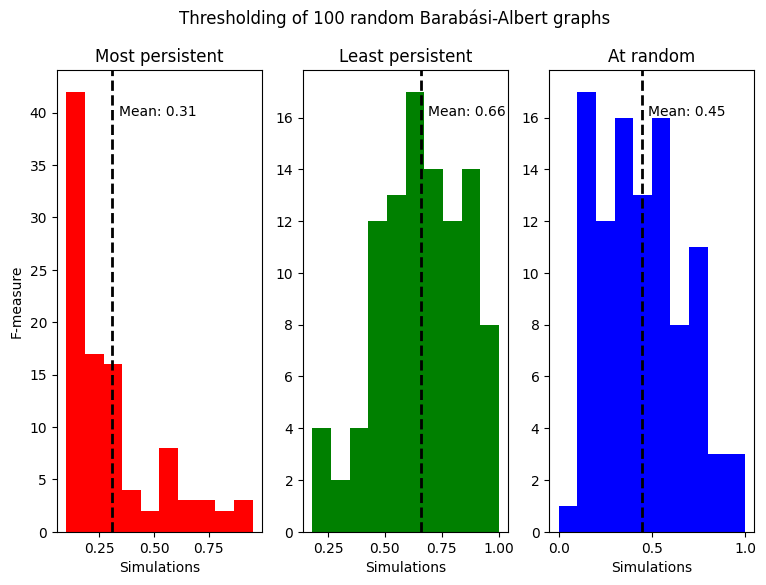

In [95]:
fig, axs = plt.subplots(1,3,figsize=(9,6))
str = ["Most persistent","Least persistent","At random"]
color = ['red','green','blue']
for i in range(3):
    axs[i].hist(BA_array[:,i],color=color[i])
    axs[i].set_title(str[i])
    axs[i].axvline(BA_array[:,i].mean(), color='black', linestyle='dashed', linewidth=2)
    axs[i].text(BA_array[:,i].mean() + 0.03, axs[i].get_ylim()[1]*0.9, f"Mean: {BA_array[:,i].mean():.2f}", color='black')

axs[0].set(xlabel='Simulations',ylabel='F-measure')
axs[2].set(xlabel='Simulations')
axs[1].set(xlabel='Simulations')

fig.suptitle('Thresholding of 100 random Barabási-Albert graphs')
plt.subplots_adjust(hspace=1)
plt.savefig("BA_thresholding.png")

In [96]:
RBF_array = np.load("trial12_typeRBF_experiments100_N20_reverseTrue.npy")

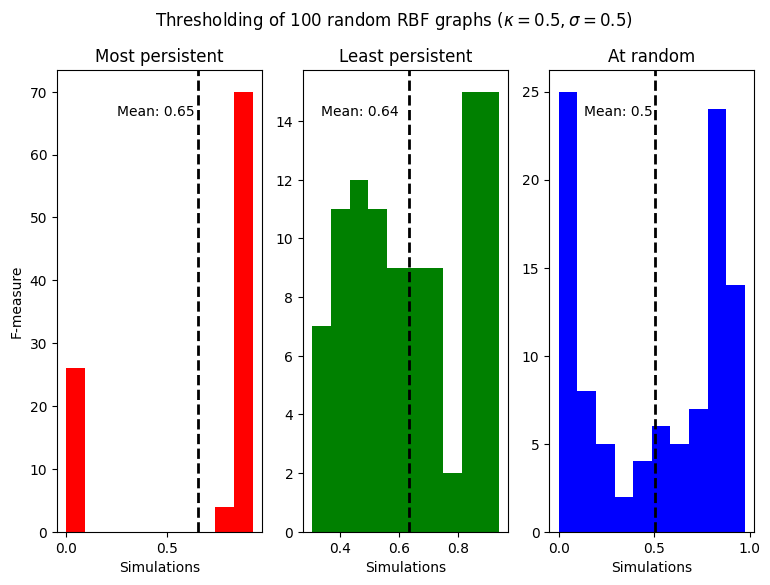

In [9]:
RBF_array = array
fig, axs = plt.subplots(1,3,figsize=(9,6))
str = ["Most persistent","Least persistent","At random"]
color = ['red','green','blue']

for i in range(3):
    axs[i].hist(RBF_array[:,i],color=color[i])
    axs[i].set_title(str[i])
    axs[i].axvline(RBF_array[:,i].mean(), color='black', linestyle='dashed', linewidth=2)
    if i==1:
        axs[i].text(RBF_array[:,i].mean() - 0.3, axs[i].get_ylim()[1]*0.9, f"Mean: {RBF_array[:,i].mean():.2f}", color='black')
    elif i==2:
        axs[i].text(RBF_array[:,i].mean() - 0.37, axs[i].get_ylim()[1]*0.9, f"Mean: {RBF_array[:,i].mean():.1f}", color='black')

    else:
        axs[i].text(RBF_array[:,i].mean() -0.4, axs[i].get_ylim()[1]*0.9, f"Mean: {RBF_array[:,i].mean():.2f}", color='black')

axs[0].set(xlabel='Simulations',ylabel='F-measure')
axs[2].set(xlabel='Simulations')
axs[1].set(xlabel='Simulations')

fig.suptitle('Thresholding of 100 random RBF graphs ($\kappa=0.5,\sigma=0.5)$')
plt.subplots_adjust(hspace=1)
plt.savefig("RBF_thresholding.png")

In [91]:
ER_array = np.load("trial15_typeER_experiments100_N20_reverseTrue_iter50.npy")


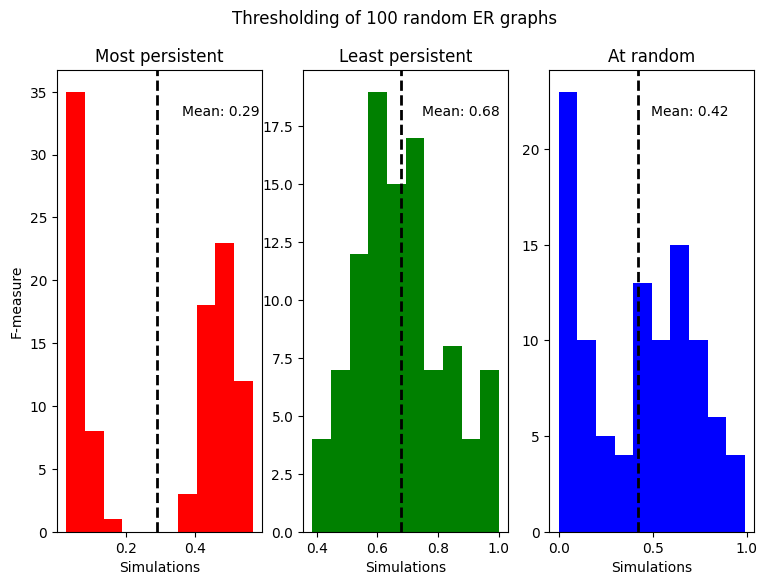

In [92]:
fig, axs = plt.subplots(1,3,figsize=(9,6))
str = ["Most persistent","Least persistent","At random"]
color = ['red','green','blue']

for i in range(3):
    axs[i].hist(ER_array[:,i],color=color[i])
    axs[i].set_title(str[i])
    axs[i].axvline(ER_array[:,i].mean(), color='black', linestyle='dashed', linewidth=2)
    if i==1:
        axs[i].text(ER_array[:,i].mean() + 0.07, axs[i].get_ylim()[1]*0.9, f"Mean: {ER_array[:,i].mean():.2f}", color='black')
    elif i==2:
        axs[i].text(ER_array[:,i].mean() + 0.07, axs[i].get_ylim()[1]*0.9, f"Mean: {ER_array[:,i].mean():.2f}", color='black')

    else:
        axs[i].text(ER_array[:,i].mean() + 0.07, axs[i].get_ylim()[1]*0.9, f"Mean: {ER_array[:,i].mean():.2f}", color='black')

axs[0].set(xlabel='Simulations',ylabel='F-measure')
axs[2].set(xlabel='Simulations')
axs[1].set(xlabel='Simulations')

fig.suptitle('Thresholding of 100 random ER graphs')
plt.subplots_adjust(hspace=1)
plt.savefig("ER_thresholding.png")

In [17]:
L = lh.heat_graph_BA(10)
X = lh.create_deltas(L,[2.5,4])
L_new = lh.learn_heat(X,tau0=[2.5,4])